## Exploratory Data Analysis

In [17]:
# import libraries
from datetime import datetime, timedelta
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division




import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go


In [18]:
# Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install chart_studio

In [11]:
#Import Data
parse_dates = ['order_purchase_timestamp',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_estimated_delivery_date',
 'shipping_limit_date',
'review_creation_date',
 'review_answer_timestamp',]

OL_Data = pd.read_csv("./OL_Data_Order_Grouped.csv", 
                      parse_dates=parse_dates,
                      date_parser = pd.to_datetime)



OL_Data.dtypes


Unnamed: 0                                int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
shipping_limit_date              datetime64[ns]
payment_installments                    float64
product_category_name_english            object
seller_id                                object
seller_zip_code_prefix                  float64
seller_city                              object
seller_state                             object
seller_latitude                         float64
seller_longitude                        float64
customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                           

<h3>RFM Scoring</h3>

<h4>Functions</h4>

In [52]:
from sklearn.cluster import KMeans

def PrintKmeansInertiaGraph(dataFrame, column):
    sse={}
    columnDF = dataFrame[[column]]
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k, max_iter=1000).fit(columnDF)
        columnDF.assign(clusters=kmeans.labels_)
        sse[k] = kmeans.inertia_ 
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.show()
    
    
def PerformKMeans(dataFrame, column, clusters):
    kmeans = KMeans(n_clusters=clusters)
    kmeans.fit(dataFrame[[column]])
    dataFrame['{0}Cluster'.format(column)] = kmeans.predict(dataFrame[[column]])

    
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

<h4>Recency</h4>

count    94467.000000
mean       241.859888
std        152.702590
min          0.000000
25%        118.000000
50%        223.000000
75%        350.000000
max        728.000000
Name: Recency, dtype: float64


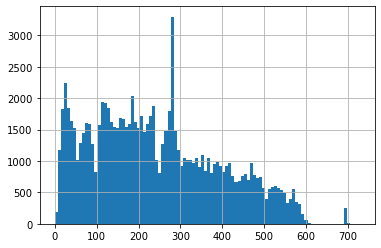

In [37]:
#Recency Score Calc
buyers = pd.DataFrame(OL_Data['customer_unique_id'].unique())
buyers.columns=['CustomerUniqueID']

buyerMaxPurchase = OL_Data.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
buyerMaxPurchase.columns = ['CustomerUniqueID', 'MaxPurchaseDate']

buyerMaxPurchase['Recency'] = (buyerMaxPurchase['MaxPurchaseDate'].max() - buyerMaxPurchase['MaxPurchaseDate']).dt.days

buyers = pd.merge(buyers, buyerMaxPurchase[['CustomerUniqueID','Recency']])

print(buyers['Recency'].describe())
buyers.Recency.sort_values().hist(bins=100)
plt.show()

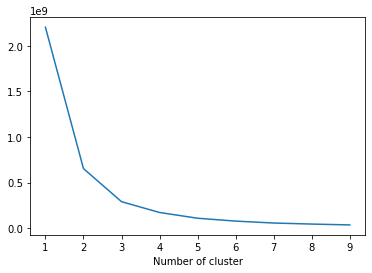

In [53]:
PrintKmeansInertiaGraph(buyers,'Recency')

count    94467.000000
mean         1.061005
std          0.289504
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         16.000000
Name: Frequency, dtype: float64


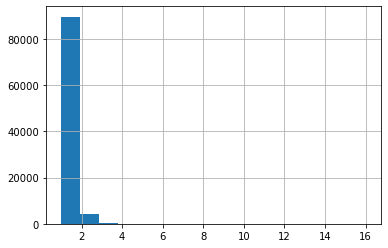

In [42]:
#Frequency
freq = OL_Data.groupby('customer_unique_id').order_id.count().reset_index()
freq.columns = ['CustomerUniqueID','Frequency']
freq.head()

buyers = pd.merge(buyers,freq, on='CustomerUniqueID')

print(buyers['Frequency'].describe())
buyers.Frequency.sort_values().hist(bins=16)
plt.show()

count    94467.000000
mean       182.890726
std        306.673979
min          0.000000
25%         63.230000
50%        108.840000
75%        188.340000
max      13664.080000
Name: Revenue, dtype: float64


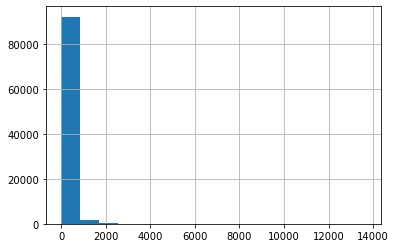

In [43]:
#Revenue
rev = OL_Data.groupby('customer_unique_id').Total_payment.sum().reset_index()
rev.columns = ['CustomerUniqueID','Revenue']

buyers = pd.merge(buyers, rev, on='CustomerUniqueID')

print(buyers['Revenue'].describe())
buyers.Revenue.sort_values().hist(bins=16)
plt.show()